In [1]:
%matplotlib inline

from py_wgpu_fdm import Simulation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


In [2]:
def generate_straight_rod(
    rest_length: float,
    tuned_length: float,
    node_count: int,
    core_radius: float = 6.0e-4,
    winding_radius: float = 4.0e-4,
    E_core: float = 2.07e11,
    G_core: float = 8.0e10,
    rho_core: float = 7.85e3,
    E_winding: float = 1.1e11,
    G_winding: float = 4.1e10,
    rho_winding: float =8.96e3,
    packing_factor: float = 0.8,

):

    # ------------------------------+------------------------------------
    # 1. Geometry
    # ------------------------------------------------------------------
    x = np.linspace(0.0, tuned_length, node_count)
    positions = np.stack([
        x,
        np.zeros_like(x),
        np.zeros_like(x),
    ], axis=1).astype(np.float32)

    dl = rest_length / float(node_count - 1)

    # ------------------------------------------------------------------
    # 2. Physics: Mass and Inertia
    # ------------------------------------------------------------------
    core_area = np.pi * core_radius**2
    core_mass = float(rho_core * core_area * dl)

    winding_area = np.pi * ( (core_radius + 2.0 * winding_radius)**2 - core_radius**2 )
    winding_mass = float(rho_winding * winding_area * dl * packing_factor)

    mass = core_mass + winding_mass

    # For circular cross sections!
    # This is "lumped inertia", i.e. rho * dl * I
    I_core = rho_core * core_radius**4 / 4.0 
    I_winding = rho_winding * ((core_radius + 2.0 * winding_radius)**4 - core_radius**4) * packing_factor / 4.0 
    
    I1 = I_core + I_winding
    I3 = I1 * 2.0
    inertia = ( np.pi * dl * np.array([I1, I1, I3], dtype=np.float32))

    # ------------------------------------------------------------------
    # 3. Nodes
    # ------------------------------------------------------------------
    nodes = [(pos, np.zeros(3, dtype=np.float32)) for pos in positions]

    # ------------------------------------------------------------------
    # 4. Edges (calculated frame, d3 aligned with tangent)
    # ------------------------------------------------------------------
    edges = []

    def get_alignment_quaternion(tangent):
        """Calculates the shortest-arc quaternion to align [0,0,1] with the tangent."""
        d3_ref = np.array([0.0, 0.0, 1.0], dtype=np.float32)
        
        # Normalize the tangent just in case
        t = tangent / (np.linalg.norm(tangent) + 1e-12)
        
        dot = np.dot(d3_ref, t)
        
        # Case 1: Already aligned
        if dot > 0.999999:
            return np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32)
        
        # Case 2: Opposite direction (180 deg rotation about any orthogonal axis)
        if dot < -0.999999:
            return np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float32)
        
        # Case 3: General case (Shortest Arc)
        # q = [ (d3_ref x t), 1 + dot ]
        cross = np.cross(d3_ref, t)
        q = np.array([cross[0], cross[1], cross[2], 1.0 + dot], dtype=np.float32)
        
        # Normalize to make it a unit quaternion
        return q / np.linalg.norm(q)

    # Calculate quaternion for each segment
    for i in range(node_count - 1):
        p0 = positions[i]
        p1 = positions[i+1]
        tangent = p1 - p0
        
        q_segment = get_alignment_quaternion(tangent)
        edges.append((q_segment, np.zeros(3, dtype=np.float32)))
    
    # Ghost edge: matching the orientation of the last real segment
    edges.append((edges[-1][0], np.zeros(3, dtype=np.float32)))

    # ------------------------------------------------------------------
    # 5. Shear-Stretch and Bending-Twist stiffness (diagonal)
    # ------------------------------------------------------------------
    A = core_area
    # shear correction for circular cross sections
    alpha = 4.0 / 3.0

    # Assumption: only the core contributes to stiffness!
    I = np.pi * core_radius**4 / 4.0
    J = np.pi * core_radius**4 / 2.0

    # Shear along 1,2; axial along tangent (3)
    K_se = np.array([G_core * A * alpha, G_core * A * alpha, E_core * A], dtype=np.float32)

    # Bending about 1,2; torsion about tangent (3)
    K_bt = np.array([E_core * I, E_core * I, G_core * J], dtype=np.float32)

    return nodes, edges, dl, mass, inertia, K_se, K_bt


In [3]:
import numpy as np

def velocity_impulse_z(
    nodes: list, 
    amplitude: float, 
    sigma: float, 
    center_node_index: int = None,
    center_x: float = None
):
    """
    Adds a Gaussian velocity profile in the Z-direction.
    
    Parameters:
    - nodes: List of (pos, vel) tuples.
    - amplitude: Peak velocity at the center (m/s).
    - sigma: Standard deviation of the Gaussian (spread in meters).
    - center_node_index: The index of the node to strike.
    - center_x: The physical X-coordinate to strike (alternative to index).
    """
    
    # 1. Determine the center X coordinate
    if center_x is not None:
        target_x = center_x
    elif center_node_index is not None:
        target_x = nodes[center_node_index][0][0] # pos.x of that node
    else:
        # Default to middle of the rod
        target_x = nodes[len(nodes) // 2][0][0]

    # 2. Apply Gaussian velocity to each node
    for pos, vel in nodes:
        # Distance from strike center along the rod
        dist = pos[0] - target_x
        
        # Gaussian formula: A * exp(-(x - x0)^2 / (2 * sigma^2))
        dv_z = amplitude * np.exp(-(dist**2) / (2.0 * sigma**2))
        
        # Add to the Z-component (index 2)
        vel[2] += dv_z

    return nodes

In [4]:
nodes, edges, dl, mass, inertia, K_se, K_bt = generate_straight_rod(
    1.4,
    1.4,
    50,
)

#nodes = velocity_impulse_z(nodes, 3.0, dl * 10, 20)

In [5]:
dl

0.02857142857142857

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_string(nodes, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    """

    positions = np.array([n[0] for n in nodes])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Plot edges as a polyline
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized String (Initial Configuration)")
    ax.legend()

    # Equal aspect ratio (important!)
    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()


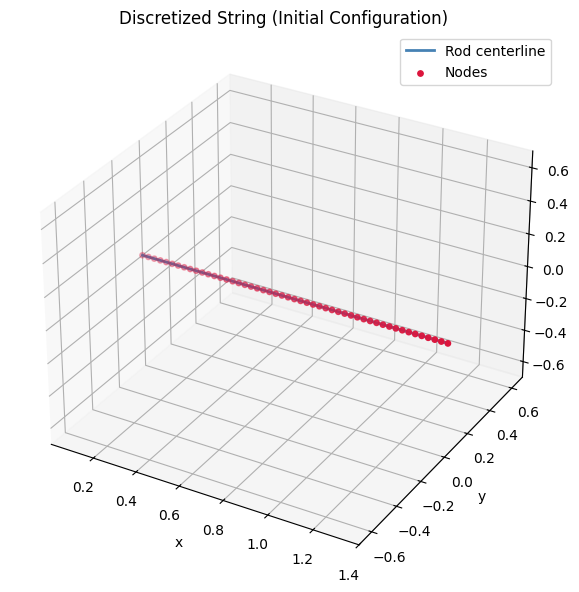

Discrete string has 50 nodes


In [7]:
plot_string(nodes)
print(f'Discrete string has {len(nodes)} nodes')

In [8]:
duration = 0.1 #seconds
sample_rate = 50000
chunk_size = 512

dt = 5e-8
oversampling_factor = 1.0 / (dt * sample_rate)
print(f'The appropriate oversampling factor for a target sample rate of {sample_rate} Hz at a delta t of {dt} would be {oversampling_factor}. This yields samples that are effectively {dt * oversampling_factor} seconds apart. Therefore one chunk of {chunk_size} samples is {dt * oversampling_factor * chunk_size} long. A duration of {duration} seconds would require {duration / (dt * oversampling_factor * chunk_size)} dispatches.')
oversampling_factor = int(oversampling_factor)


The appropriate oversampling factor for a target sample rate of 50000 Hz at a delta t of 5e-08 would be 400.0. This yields samples that are effectively 1.9999999999999998e-05 seconds apart. Therefore one chunk of 512 samples is 0.010239999999999999 long. A duration of 0.1 seconds would require 9.765625000000002 dispatches.


In [9]:

sim = Simulation(
    nodes=nodes,
    edges=edges,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dl,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
)
 

In [10]:
sim.initialize(0.0, 1)

Initializing simulation!


In [11]:
%%time

node_frames = list()
edge_frames = list()

for i in range(15):
    sim.compute()
    n, e = sim.save()
    node_frames.extend(n)
    edge_frames.extend(e)

CPU times: user 22min 19s, sys: 8min 51s, total: 31min 11s
Wall time: 19min 52s


In [19]:
len(edge_frames)

7680

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def plot_string_from_frames(frames, frame_idx=-1, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    """
    nodes = frames[frame_idx]
    positions = np.array([n[0] for n in nodes])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Plot edges as a polyline
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized String (Initial Configuration)")
    ax.legend()

    # Equal aspect ratio (important!)
    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()


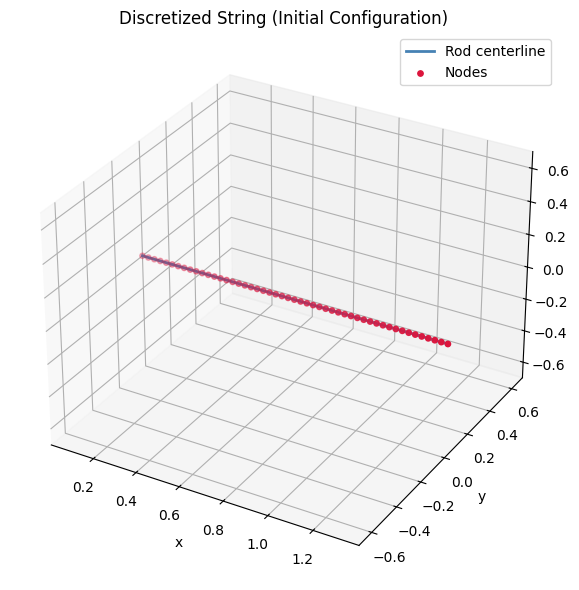

In [14]:

plot_string_from_frames(node_frames)

In [15]:
for f in node_frames:
    n = f[20]
    print(n[0])

[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.5714285969734192, 0.0, 0.0]
[0.57142

In [16]:
for e in edge_frames[0]:
    print(e[1])

[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0], [0

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_node_pos_vel_moment_fft(
    nodes_history,
    nodes0,
    dt: float,
    oversampling_factor: float,
    node_index: int | None = None,
    moments: bool = False,
):
    """
    nodes_history[t][i] = (pos, vel, moment)
    nodes0[i]           = (pos0, vel0, moment0)
    pos, vel, moment: np.ndarray (3,)
    """

    T = len(nodes_history)
    N = len(nodes_history[0])

    if node_index is None:
        node_index = N // 2

    time = np.arange(T) * dt * oversampling_factor
    freqs = np.fft.rfftfreq(T, dt * oversampling_factor)

    # ------------------------------------------------------------
    # Rest position
    # ------------------------------------------------------------
    pos0, _ = nodes0[node_index]

    # ------------------------------------------------------------
    # Extract history
    # ------------------------------------------------------------
    pos = np.zeros((T, 3), dtype=np.float32)
    vel = np.zeros((T, 3), dtype=np.float32)
    mom = np.zeros((T, 3), dtype=np.float32)

    for t in range(T):
        p, v, m = nodes_history[t][node_index]
        pos[t] = p - pos0   # displacement only
        vel[t] = v
        mom[t] = m          # absolute moment

    pos_mag = np.linalg.norm(pos, axis=1)
    vel_mag = np.linalg.norm(vel, axis=1)
    mom_mag = np.linalg.norm(mom, axis=1)

    components = [
        ("x", pos[:, 0], vel[:, 0], mom[:, 0]),
        ("y", pos[:, 1], vel[:, 1], mom[:, 1]),
        ("z", pos[:, 2], vel[:, 2], mom[:, 2]),
        ("|·|", pos_mag, vel_mag, mom_mag),
    ]

    # ------------------------------------------------------------
    # FFT helper (on displacement)
    # ------------------------------------------------------------
    def fft_mag(signal):
        fft = np.fft.rfft(signal - np.mean(signal))
        return np.abs(fft)

    # ------------------------------------------------------------
    # Plot per component
    # ------------------------------------------------------------
    for label, p_data, v_data, m_data in components:

        n_plots = 2 + int(moments)
        fig, axes = plt.subplots(
            n_plots, 1,
            figsize=(10, 2.8 * n_plots),
            sharex=False,
        )

        if n_plots == 1:
            axes = [axes]

        # ========================================================
        # 1. Displacement + Velocity (time)
        # ========================================================
        ax = axes[0]

        p_max = np.max(np.abs(p_data))
        v_max = np.max(np.abs(v_data))

        p_scaled = p_data / p_max if p_max > 0 else p_data
        v_scaled = v_data / v_max if v_max > 0 else v_data

        ax.plot(time, p_scaled, color="tab:blue")
        ax.set_ylim(-1.05, 1.05)
        ax.set_ylabel(f"{label} disp", color="tab:blue")
        ax.tick_params(axis="y", labelcolor="tab:blue")
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([f"{-p_max:.3e}", "0", f"{p_max:.3e}"])

        ax2 = ax.twinx()
        ax2.plot(time, v_scaled, "--", color="tab:orange")
        ax2.set_ylim(-1.05, 1.05)
        ax2.set_ylabel(f"{label} vel", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        ax2.set_yticks([-1, 0, 1])
        ax2.set_yticklabels([f"{-v_max:.3e}", "0", f"{v_max:.3e}"])

        ax.set_title(f"{label} — displacement & velocity (time)")
        ax.grid(True, alpha=0.3)

        # ========================================================
        # 2. Moment (absolute, time)
        # ========================================================
        plot_idx = 1
        if moments:
            axm = axes[plot_idx]

            m_max = np.max(np.abs(m_data))
            m_scaled = m_data / m_max if m_max > 0 else m_data

            axm.plot(time, m_scaled, color="tab:green")
            axm.set_ylim(-1.05, 1.05)
            axm.set_ylabel(f"{label} moment")
            axm.set_yticks([-1, 0, 1])
            axm.set_yticklabels([f"{-m_max:.3e}", "0", f"{m_max:.3e}"])
            axm.set_title(f"{label} — moment (time)")
            axm.grid(True, alpha=0.3)

            plot_idx += 1

        # ========================================================
        # 3. FFT of displacement
        # ========================================================
        bins = fft_mag(p_data)
        idx = np.argmax(bins[1:]) + 1

        largest_component = freqs[idx]
        print(f'{label} FFT max frequency at {largest_component}')
        axf = axes[plot_idx]
        axf.plot(freqs, bins, color="tab:blue")
        axf.set_ylabel("FFT |disp|")
        axf.set_xlabel("Frequency [Hz]")
        axf.set_title(f"{label} — displacement FFT")

        # Limit FFT plot to 20 kHz
        axf.set_xlim(0, 20000)  # Limit frequency to 20kHz
        axf.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


x FFT max frequency at 6.510416666666667


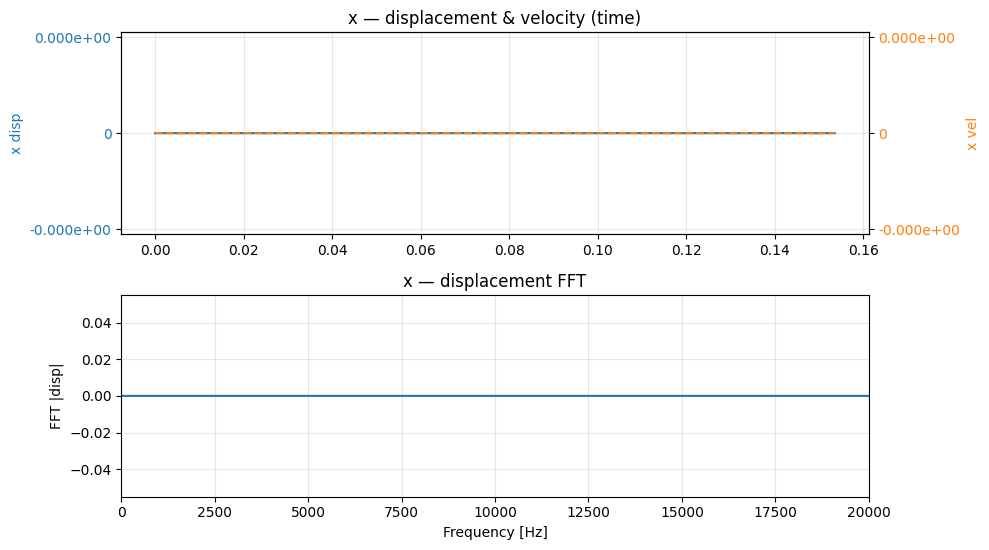

y FFT max frequency at 6.510416666666667


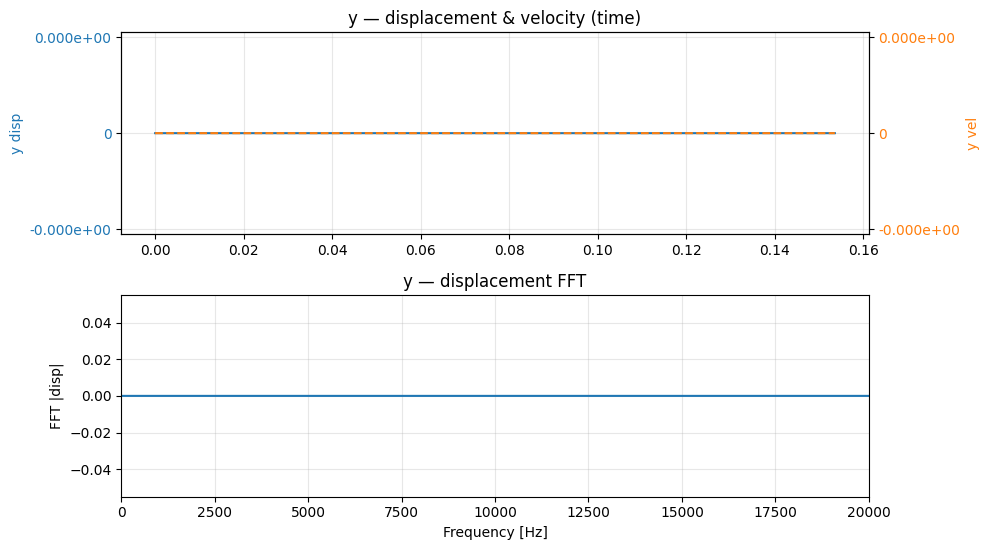

z FFT max frequency at 6.510416666666667


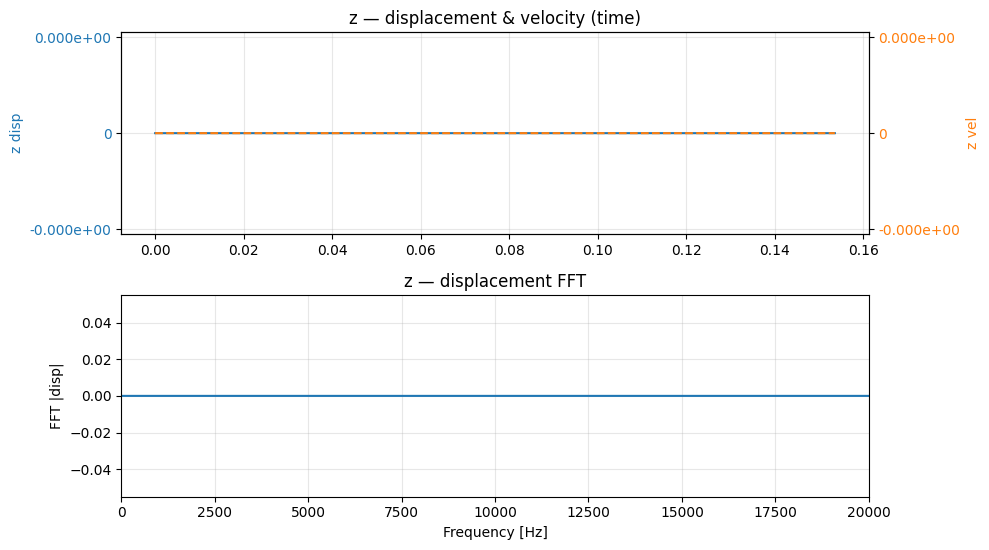

|·| FFT max frequency at 6.510416666666667


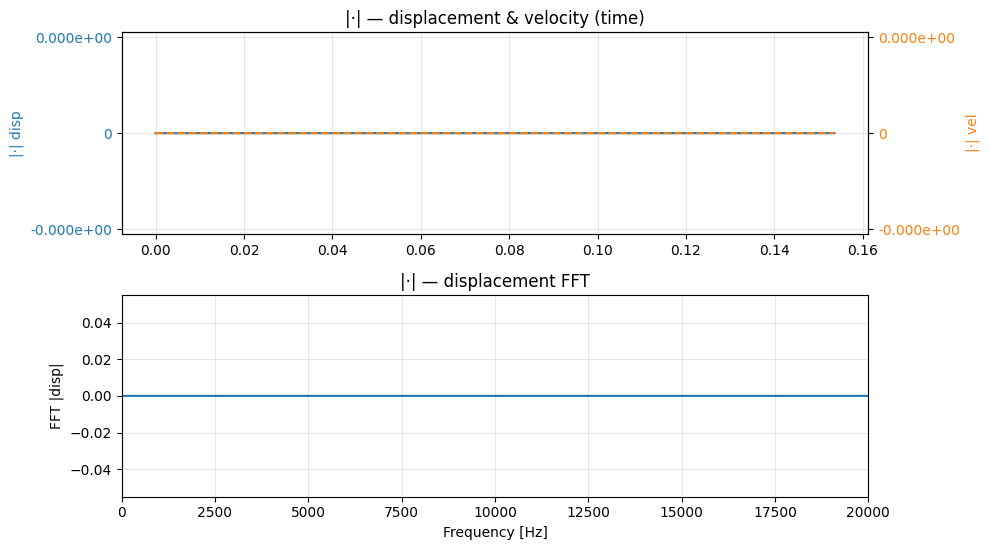

In [20]:
plot_node_pos_vel_moment_fft(node_frames, nodes, dt, oversampling_factor, node_index=40)

In [34]:
import numpy as np
import sounddevice as sd

def play_rod_displacement_as_audio(nodes_over_time, 
                                   component='z', 
                                   node_index=None, 
                                   sample_rate=44100):
    """
    Play a rod displacement as audio.

    Args:
        nodes_over_time : list of node snapshots over time
            each snapshot is list of tuples [(pos, vel), ...]
        component : 'x', 'y', 'z' or 'abs'
        node_index : int, which node to use; None = center node
        sample_rate : audio sample rate in Hz
    """
    comp_map = {'x': 0, 'y': 1, 'z': 2, 'abs': None}
    
    if component not in comp_map:
        raise ValueError("component must be 'x','y','z','abs'")

    node_count = len(nodes_over_time[0])
    if node_index is None:
        node_index = node_count // 2  # center node

    # Extract displacement over time
    disp = []
    for snapshot in nodes_over_time:
        pos, _, _ = snapshot[node_index]
        if component == 'abs':
            val = np.linalg.norm(pos)
        else:
            val = pos[comp_map[component]]
        disp.append(val)
    
    disp = np.array(disp, dtype=np.float32)

    # Normalize to [-1,1]
    disp -= disp.mean()
    max_val = np.max(np.abs(disp))
    if max_val > 0:
        disp /= max_val

    # Resample to match sample rate if needed
    from scipy.signal import resample
    n_samples = len(disp)
    duration = n_samples / sample_rate
    audio = resample(disp, int(duration * sample_rate))

    # Play audio
    sd.play(audio, samplerate=sample_rate)
    sd.wait()


In [20]:
fs = 1.0 / (dt * oversampling_factor)
print(fs)
play_rod_displacement_as_audio(node_frames, component='z', sample_rate=fs)

50000.00000000001
